In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *
import json
from urllib.error import URLError,HTTPError
import time
from pathlib import Path

In [2]:
def search_images_ddg(term, max_images=200):
    "Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images"
    print(f'searching for {term}')
    assert max_images<1000
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    assert searchObj
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    headers = dict(referer='https://duckduckgo.com/')
    while len(urls)<max_images and 'next' in data:
        try:
            res = urlread(requestUrl, data=params, headers=headers)
            data = json.loads(res) if res else {}
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
        except (URLError,HTTPError): pass
        time.sleep(1)
    return L(urls)[:max_images]

In [3]:
# create DIR for notebook and set current DIR
NOTEBOOK_DIR = "Deployment"
Path(NOTEBOOK_DIR).mkdir(parents=True, exist_ok=True)

searching for car


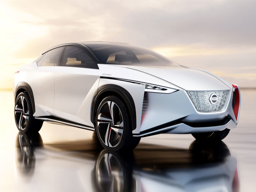

In [4]:
from fastdownload import download_url
from fastai.vision.all import *

dest = NOTEBOOK_DIR + '/car.jpg'
urls = search_images_ddg("car", max_images=1)
download_url(urls[0], dest)


im = Image.open(dest)
im.to_thumb(256, 256)

searching for plane photos


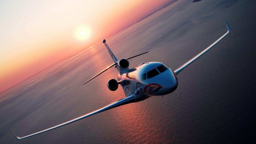

In [5]:
dest = NOTEBOOK_DIR + '/plane.jpg'
urls = search_images_ddg("plane photos", max_images=1)
download_url(urls[0], dest)


im = Image.open(dest)
im.to_thumb(256, 256)

searching for bus photos


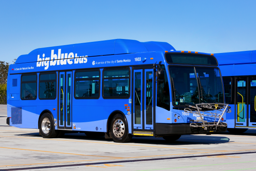

In [6]:
dest = NOTEBOOK_DIR + '/bus.jpg'
urls = search_images_ddg("bus photos", max_images=1)
download_url(urls[0], dest)


im = Image.open(dest)
im.to_thumb(256, 256)

In [7]:
searches = ['car', 'plane', 'bus']
path = Path(NOTEBOOK_DIR+'/images')

for search in searches:
    dest = (path/search)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images_ddg(f'{search}', max_images=30))
    time.sleep(10)
    download_images(dest, urls=search_images_ddg(f'{search} sunset', max_images=30))
    time.sleep(10)
    resize_images(dest, max_size=400, dest=dest)
    print("Resized complete")
    
    
    

searching for car
searching for car sunset
Resized complete
searching for plane
searching for plane sunset
Resized complete
searching for bus
searching for bus sunset
Resized complete


In [8]:
# remove failed images

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

9

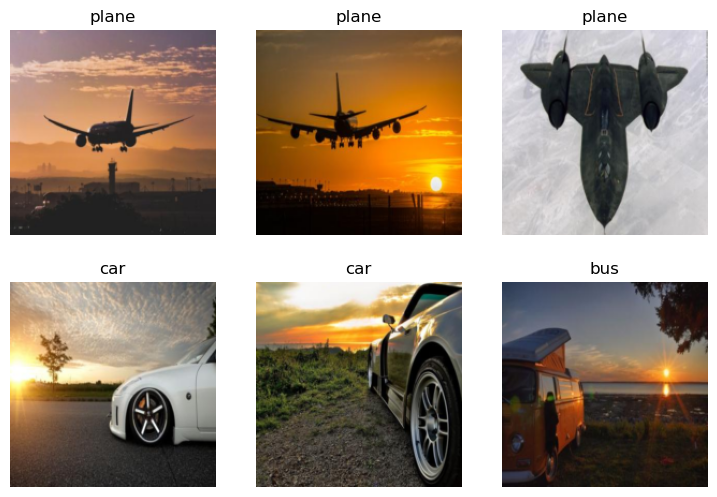

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)


In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/sachin/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sachin/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/sachin/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:09<00:00, 4.75MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.543695,3.765642,0.700000,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.711539,1.189106,0.433333,00:19
1,0.568874,0.291826,0.100000,00:18
2,0.402959,0.163907,0.066667,00:18


In [24]:
def get_output(file_name):
    file_path = NOTEBOOK_DIR + f'/{file_name}'
    label,index,probs = learn.predict(PILImage.create(file_path))
    print(index)
    print(f"This is a {label}.")
    print(f"Probability it's a bus: {probs[0]:.4f}")
    print(f"Probability it's a car: {probs[1]:.4f}")
    print(f"Probability it's a plane: {probs[2]:.4f}")
    im = Image.open(file_path)
    return im.to_thumb(256, 256)

tensor(2)
This is a plane.
Probability it's a bus: 0.0813
Probability it's a car: 0.0128
Probability it's a plane: 0.9060


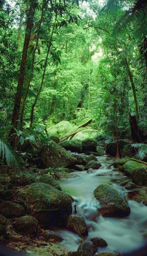

In [28]:
get_output('forest.jpg')

searching for forest photos


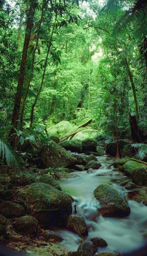

In [16]:
# cross test

dest = NOTEBOOK_DIR + '/forest.jpg'
urls = search_images_ddg("forest photos", max_images=1)
download_url(urls[0], dest)


im = Image.open(dest)
im.to_thumb(256, 256)

In [18]:
get_output('forest.jpg')

tensor(2)
This is a plane.
Probability it's a bus: 0.0813
Probability it's a car: 0.0128
Probability it's a plane: 0.9060


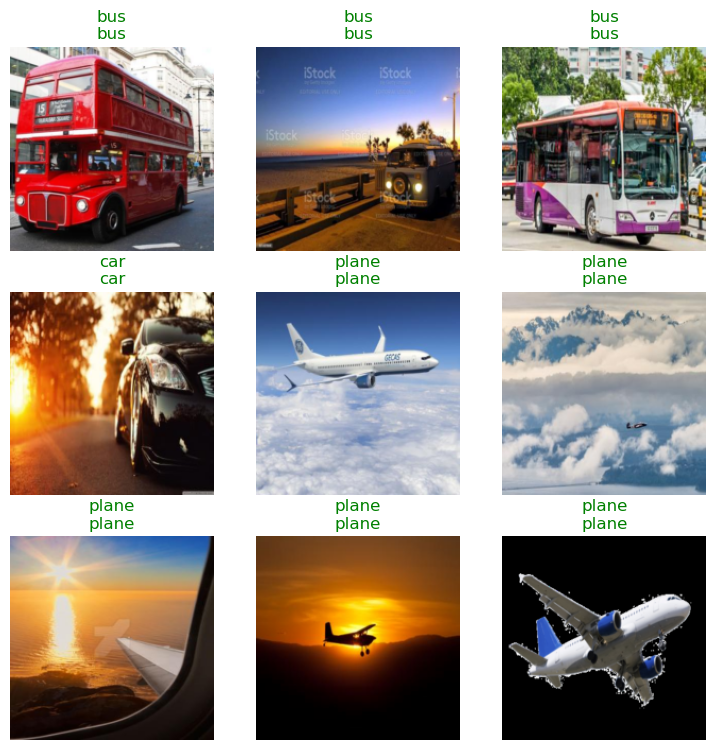

In [13]:
learn.show_results()